# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib_venn import venn3, venn2
import random
import plotly.io as pio
from scipy import sparse
import os

In [2]:
seed = 16
random.seed(seed)
np.random.seed(seed)

#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
#plt.rcParams['axes.facecolor'] = 'white'
#plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

sns.set_style("darkgrid", rc={'xtick.bottom': True})

In [3]:
data_processed = "../../../data/processed/"
data_interim = "../../../data/interim/"
data_external = "../../../data/external/"
tfidf_reports = "../../../reports/tfidf/"

graph_node_data = pd.read_csv(data_processed+"graph_data/grafo_alternativo_CG_nodos.csv")
disease_attributes = pd.read_csv(data_interim+"grafo_alternativo_disease_attributes.csv")

nodos_bert = graph_node_data.loc[graph_node_data.node_type == "bert_group",["node_index","node_id","node_name","node_source"]].copy()
disease_attributes = pd.concat([disease_attributes,nodos_bert])

enfermedades_en_dd = graph_node_data.loc[graph_node_data.degree_dd != 0, "node_index"].values
disease_attributes = disease_attributes.set_index("node_index").loc[enfermedades_en_dd].reset_index()

disease_attributes = pd.merge(graph_node_data[["node_index","comunidades_infomap","comunidades_louvain"]],disease_attributes,left_on="node_index",right_on="node_index",how="right")

# Cargo archivos

In [4]:
def load_sparse_dataframe(matrix_path,row_path,column_path,cols_str=True):
    mat = sparse.load_npz(matrix_path)
    row = np.loadtxt(row_path)
    if cols_str:
        col = np.loadtxt(column_path, dtype="str")
    else:
        col = np.loadtxt(column_path)
        
    df = pd.DataFrame.sparse.from_spmatrix(mat, index=row, columns=col)
    return df

In [39]:
#Analisis previos
infomap_clusters = pd.read_pickle("../../../reports/tfidf/infomap_analysis_checkpoint.pkl")
louvain_clusters = pd.read_pickle("../../../reports/tfidf/louvain_analysis_checkpoint.pkl")

In [6]:
# Document-Term-Matrix  de clusters

path_infomap = data_processed + "tfidf_infomap/"
path_louvain = data_processed + "tfidf_louvain/"

monograms_infomap = load_sparse_dataframe(path_infomap + "matriz_tfidf_infomap_0.npz",path_infomap + "rows_tfidf_infomap_0.txt", path_infomap+"cols_tfidf_infomap_0.txt")
monograms_louvain = load_sparse_dataframe(path_louvain + "matriz_tfidf_louvain_0.npz",path_louvain + "rows_tfidf_louvain_0.txt", path_louvain+"cols_tfidf_louvain_0.txt")

bigrams_infomap = load_sparse_dataframe(path_infomap + "matriz_tfidf_infomap_1.npz",path_infomap + "rows_tfidf_infomap_1.txt", path_infomap+"cols_tfidf_infomap_1.txt")
bigrams_louvain = load_sparse_dataframe(path_louvain + "matriz_tfidf_louvain_1.npz",path_louvain + "rows_tfidf_louvain_1.txt", path_louvain+"cols_tfidf_louvain_1.txt")

trigrams_infomap = load_sparse_dataframe(path_infomap + "matriz_tfidf_infomap_2.npz",path_infomap + "rows_tfidf_infomap_2.txt", path_infomap+"cols_tfidf_infomap_2.txt")
trigrams_louvain = load_sparse_dataframe(path_louvain + "matriz_tfidf_louvain_2.npz",path_louvain + "rows_tfidf_louvain_2.txt", path_louvain+"cols_tfidf_louvain_2.txt")

infomap_dtm = [monograms_infomap, bigrams_infomap, trigrams_infomap]
louvain_dtm = [monograms_louvain, bigrams_louvain, trigrams_louvain]

In [8]:
# Document-Term-Matrix de nodos
path = data_processed + "tfidf_nodos/"
monograms_dtm = load_sparse_dataframe(path+"matriz_nodos_tfidf_0.npz",path+"rows_tfidf_nodos_0.txt",path+"cols_tfidf_nodos_0.txt")
bigrams_dtm = load_sparse_dataframe(path+"matriz_nodos_tfidf_1.npz",path+"rows_tfidf_nodos_1.txt",path+"cols_tfidf_nodos_1.txt")
trigrams_dtm = load_sparse_dataframe(path+"matriz_nodos_tfidf_2.npz",path+"rows_tfidf_nodos_2.txt",path+"cols_tfidf_nodos_2.txt")

document_term_matrix = [monograms_dtm, bigrams_dtm, trigrams_dtm]

In [9]:
# Matrices de similaridad de nodos

path = data_processed+ "tfidf_nodos/"
document_similarity_matrix = []

for i in range(3):
    matrix_path = path + "similaridad_nodos_tfidf_" + str(i) + ".npz"
    document_similarity_matrix.append(load_sparse_dataframe(matrix_path,path+"similarity_matrix_index.txt",path+"similarity_matrix_index.txt",cols_str=False))

# Similaridad media

## Calculo y grafico

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

In [36]:
def mean_similarity(similarity_matrix, cluster, algoritmo):
    nodos_cluster = disease_attributes[disease_attributes[algoritmo] == cluster].node_index.values
    cluster_matrix = similarity_matrix.loc[nodos_cluster,nodos_cluster]
    return round(np.mean(cluster_matrix.values), 2)

def mean_similarity_triu(similarity_matrix, cluster, algoritmo):
    nodos_cluster = disease_attributes[disease_attributes[algoritmo] == cluster].node_index.values
    cluster_matrix = similarity_matrix.loc[nodos_cluster,nodos_cluster].values
    return round(np.mean(np.triu(cluster_matrix,1)), 2)

def get_similarity(document_term_matrix,df=True):
    ids = document_term_matrix.index.values
    scores = sparse.csr_matrix(document_term_matrix.values)
    similarity_matrix = cosine_similarity(scores,scores,False)
    if df:
        similarity_matrix = pd.DataFrame.sparse.from_spmatrix(similarity_matrix, index=ids, columns=ids)
    return similarity_matrix

Armo matrices de similaridad y las guardo en formato sparse

In [34]:
# document_similarity_matrix = []
# for dtm in document_term_matrix:
#     document_similarity_matrix.append(get_similarity(dtm,False))

In [40]:
# path = data_processed+ "tfidf_nodos/"
# ids = monograms_dtm.index.values
# np.savetxt(path+"similarity_matrix_index.txt",ids)

# for i,vals in enumerate(document_similarity_matrix):
#     sparse.save_npz(f"{path}similaridad_nodos_tfidf_{i}.npz",vals)

Calculo similaridad media

In [40]:
similarity_cases = ["mean_similarity_mono_triu","mean_similarity_bi_triu","mean_similarity_tri_triu"]
for i,case in enumerate(similarity_cases):
    infomap_similarity = pd.Series({cluster:mean_similarity_triu(document_similarity_matrix[i], cluster, "comunidades_infomap") for cluster in infomap_clusters.comunidad.values}, name=case)
    louvain_similarity = pd.Series({cluster:mean_similarity_triu(document_similarity_matrix[i], cluster, "comunidades_louvain") for cluster in louvain_clusters.comunidad.values}, name=case)

    infomap_clusters = pd.merge(infomap_clusters,infomap_similarity, left_on="comunidad",right_index=True)
    louvain_clusters = pd.merge(louvain_clusters,louvain_similarity, left_on="comunidad",right_index=True)

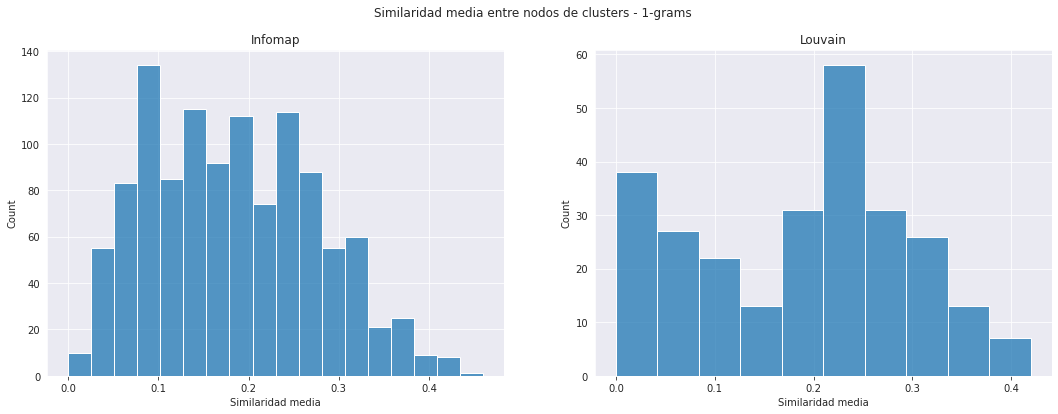

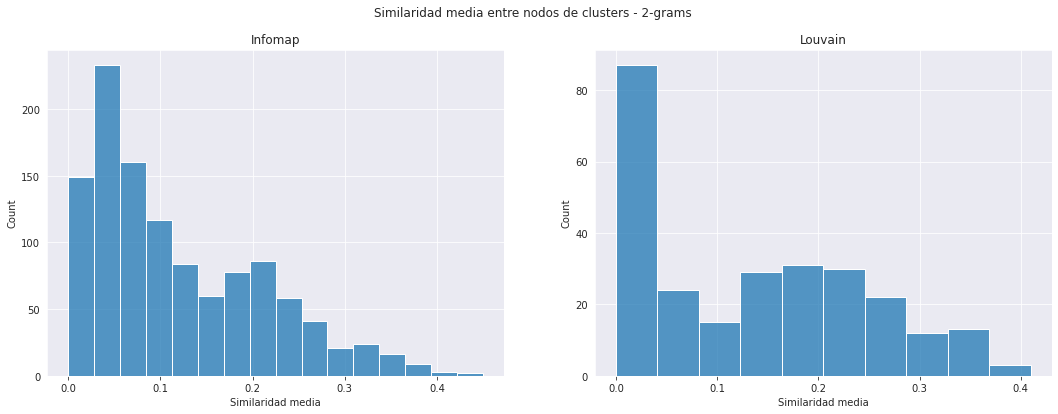

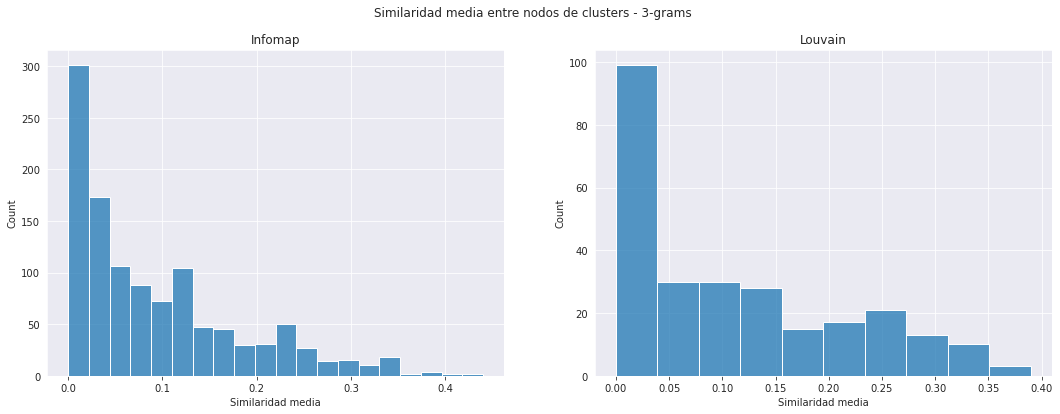

In [41]:
similarity_cases = ["mean_similarity_mono_triu","mean_similarity_bi_triu","mean_similarity_tri_triu"]
# similarity_cases = ["mean_similarity_mono","mean_similarity_bi","mean_similarity_tri"]

for i, case in enumerate(similarity_cases):
    fig, ax = plt.subplots(1,2,figsize=(18,6))
    fig.suptitle(f"Similaridad media entre nodos de clusters - {i+1}-grams")
    # ticks = np.logspace(0,tamaños_infomap.max(),10)

    sns.histplot(data=infomap_clusters[case], ax=ax[0])
    ax[0].set_xlabel("Similaridad media")
    ax[0].set_title("Infomap")

    sns.histplot(data=louvain_clusters[case], ax=ax[1])
    ax[1].set_xlabel("Similaridad media")
    ax[1].set_title("Louvain")

## Similaridad de todos los nodos

In [20]:
similaridad_todos = cosine_similarity(sparse.csr_matrix(document_term_matrix[0].values),sparse.csr_matrix(document_term_matrix[0].values),False)
similaridad_todos_triu = np.triu(similaridad_todos.todense(),1)
all_values = np.reshape(similaridad_todos_triu,(1,-1))[0]

Text(0, 0.5, 'Density')

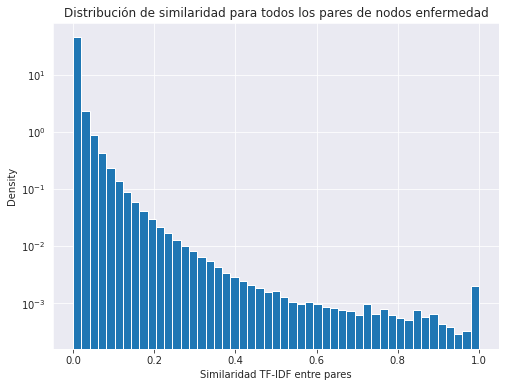

In [44]:
plt.figure(figsize=(8,6))
plot = plt.hist(all_values,bins=np.linspace(0,1,50),log=True, density=True)
plt.title("Distribución de similaridad para todos los pares de nodos enfermedad")
plt.xlabel("Similaridad TF-IDF entre pares")
plt.ylabel("Density")
# plt.savefig(tfidf_reports+"similaridad_todos.png",dpi=200)

## P valores por cluster

In [ ]:
#aca hacer cosa de p valores

# Entropía

### Cargo entropías random

In [52]:
paths_infomap = [tfidf_reports+"entropia_random_infomap_"+case+".txt" for case in ["mono","bi","tri"]]
paths_louvain = [tfidf_reports+"entropia_random_louvain_"+case+".txt" for case in ["mono","bi","tri"]]

entropias_random_infomap = {n:np.loadtxt(path) for n,path in enumerate(paths_infomap)}
entropias_random_louvain = {n:np.loadtxt(path) for n,path in enumerate(paths_louvain)}

means_random_infomap = {}
stds_random_infomap = {}

for i,res in entropias_random_infomap.items():
    means = [np.mean(arr) for arr in np.array(res).T]
    stds = [np.std(arr) for arr in np.array(res).T]

    means_random_infomap[i] = means
    stds_random_infomap[i] = stds


means_random_louvain = {}
stds_random_louvain = {}

for i,res in entropias_random_louvain.items():
    means = [np.mean(arr) for arr in np.array(res).T]
    stds = [np.std(arr) for arr in np.array(res).T]

    means_random_louvain[i] = means
    stds_random_louvain[i] = stds

In [53]:
ids_random_infomap = infomap_clusters.drop_duplicates(subset="tamaño").comunidad.values
tamaños_random_infomap = infomap_clusters.set_index("comunidad").loc[ids_random_infomap,"tamaño"].values

ids_random_louvain = louvain_clusters.drop_duplicates(subset="tamaño").comunidad.values
tamaños_random_louvain = louvain_clusters.set_index("comunidad").loc[ids_random_louvain,"tamaño"].values

### Calculo entropías medidas

In [54]:
infomap_clusters_temp = infomap_clusters.copy()
infomap_clusters_mean_s = infomap_clusters_temp[["tamaño","entropia_1","entropia_2","entropia_3"]].groupby(["tamaño"]).mean().fillna(0)
infomap_clusters_std_s = infomap_clusters_temp[["tamaño","entropia_1","entropia_2","entropia_3"]].groupby(["tamaño"]).std().fillna(0)

louvain_clusters_temp = louvain_clusters.copy()
louvain_clusters_mean_s = louvain_clusters_temp[["tamaño","entropia_1","entropia_2","entropia_3"]].groupby(["tamaño"]).mean().fillna(0)
louvain_clusters_std_s = louvain_clusters_temp[["tamaño","entropia_1","entropia_2","entropia_3"]].groupby(["tamaño"]).std().fillna(0)

### Graficos de entropía medida vs entropía random

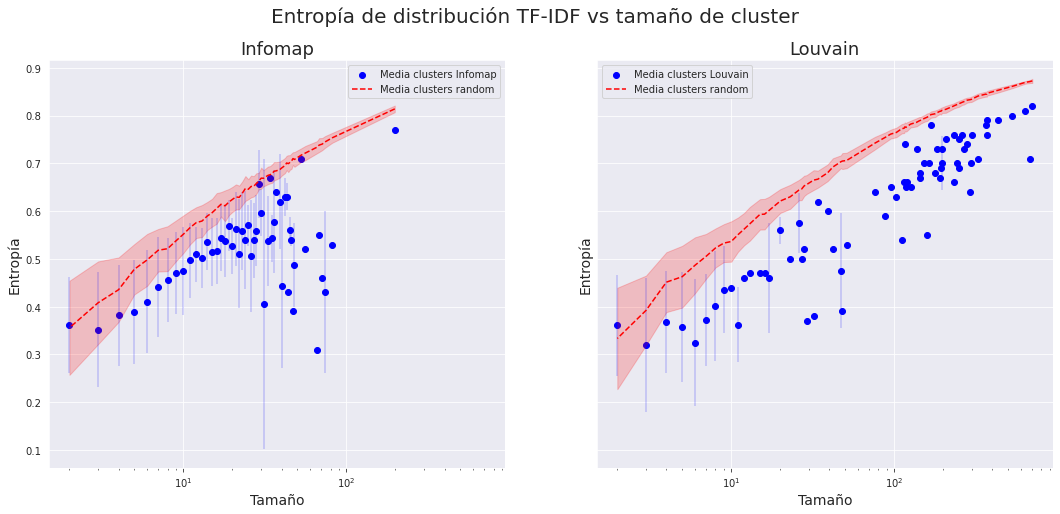

In [68]:
x1, y1, std1 = infomap_clusters_mean_s.index.values, infomap_clusters_mean_s.entropia_1.values, infomap_clusters_std_s.entropia_1.values
x1_random, y1_random, std1_random = tamaños_random_infomap, np.array(means_random_infomap[0]),  np.array(stds_random_infomap[0])

fig, ax = plt.subplots(1,2,figsize=(18,7.5), sharex=True, sharey=True)
fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster",fontsize=20)
ax[0].scatter(x1 , y1, c="b",linestyle='None', label="Media clusters Infomap")
ax[0].errorbar(x1, y1,std1, color='b',linestyle='None', alpha=0.2)

ax[0].plot(x1_random , y1_random, "r--", label="Media clusters random")
ax[0].fill_between(x1_random, y1_random - std1_random, y1_random + std1_random, color='r', alpha=0.2)

ax[0].set_title("Infomap", fontsize=18)
ax[0].grid(True)
ax[0].set_xlabel("Tamaño", fontsize=14)
ax[0].set_ylabel("Entropía", fontsize=14)
ax[0].set_xscale("log")
ax[0].legend()


x2, y2, std2 = louvain_clusters_mean_s.index.values, louvain_clusters_mean_s.entropia_1.values, louvain_clusters_std_s.entropia_1.values
x2_random, y2_random, std2_random = tamaños_random_louvain, np.array(means_random_louvain[0]), np.array(stds_random_louvain[0])
ax[1].scatter(x2 , y2, c="b",linestyle='None', label="Media clusters Louvain")
ax[1].errorbar(x2, y2, std2, color='b',linestyle='None', alpha=0.2)

ax[1].plot(x2_random , y2_random, "r--", label="Media clusters random")
ax[1].fill_between(x2_random, y2_random - std2_random, y2_random + std2_random, color='r', alpha=0.2)

ax[1].set_title("Louvain", fontsize=18)
ax[1].grid(True)
ax[1].set_xlabel("Tamaño", fontsize=14)
ax[1].set_ylabel("Entropía", fontsize=14)
ax[1].set_xscale("log")
ax[1].legend()

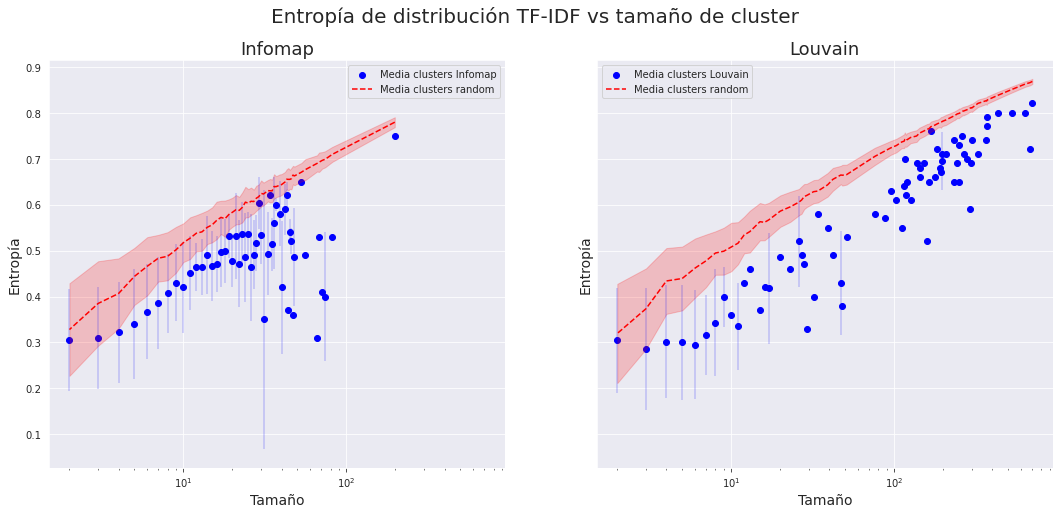

In [73]:
x1, y1, std1 = infomap_clusters_mean_s.index.values, infomap_clusters_mean_s.entropia_2.values, infomap_clusters_std_s.entropia_2.values
x1_random, y1_random, std1_random = tamaños_random_infomap, np.array(means_random_infomap[1]),  np.array(stds_random_infomap[1])

fig, ax = plt.subplots(1,2,figsize=(18,7.5), sharex=True, sharey=True)
fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster",fontsize=20)
ax[0].scatter(x1 , y1, c="b",linestyle='None', label="Media clusters Infomap")
ax[0].errorbar(x1, y1,std1, color='b',linestyle='None', alpha=0.2)

ax[0].plot(x1_random , y1_random, "r--", label="Media clusters random")
ax[0].fill_between(x1_random, y1_random - std1_random, y1_random + std1_random, color='r', alpha=0.2)

ax[0].set_title("Infomap", fontsize=18)
ax[0].grid(True)
ax[0].set_xlabel("Tamaño", fontsize=14)
ax[0].set_ylabel("Entropía", fontsize=14)
ax[0].set_xscale("log")
ax[0].legend()


x2, y2, std2 = louvain_clusters_mean_s.index.values, louvain_clusters_mean_s.entropia_2.values, louvain_clusters_std_s.entropia_2.values
x2_random, y2_random, std2_random = tamaños_random_louvain, np.array(means_random_louvain[1]), np.array(stds_random_louvain[1])
ax[1].scatter(x2 , y2, c="b",linestyle='None', label="Media clusters Louvain")
ax[1].errorbar(x2, y2, std2, color='b',linestyle='None', alpha=0.2)

ax[1].plot(x2_random , y2_random, "r--", label="Media clusters random")
ax[1].fill_between(x2_random, y2_random - std2_random, y2_random + std2_random, color='r', alpha=0.2)

ax[1].set_title("Louvain", fontsize=18)
ax[1].grid(True)
ax[1].set_xlabel("Tamaño", fontsize=14)
ax[1].set_ylabel("Entropía", fontsize=14)
ax[1].set_xscale("log")
ax[1].legend()

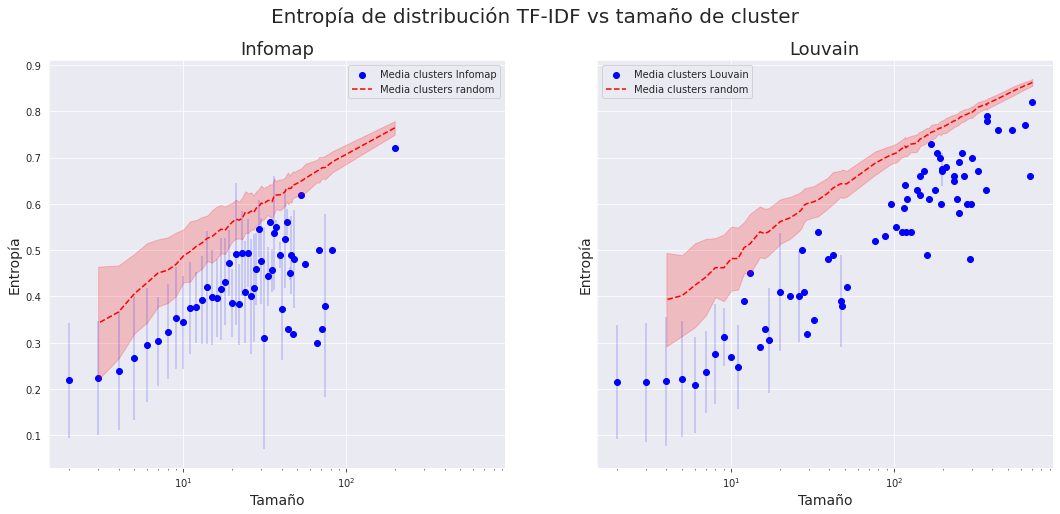

In [74]:
x1, y1, std1 = infomap_clusters_mean_s.index.values, infomap_clusters_mean_s.entropia_3.values, infomap_clusters_std_s.entropia_3.values
x1_random, y1_random, std1_random = tamaños_random_infomap, np.array(means_random_infomap[2]),  np.array(stds_random_infomap[2])

fig, ax = plt.subplots(1,2,figsize=(18,7.5), sharex=True, sharey=True)
fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster",fontsize=20)
ax[0].scatter(x1 , y1, c="b",linestyle='None', label="Media clusters Infomap")
ax[0].errorbar(x1, y1,std1, color='b',linestyle='None', alpha=0.2)

ax[0].plot(x1_random , y1_random, "r--", label="Media clusters random")
ax[0].fill_between(x1_random, y1_random - std1_random, y1_random + std1_random, color='r', alpha=0.2)

ax[0].set_title("Infomap", fontsize=18)
ax[0].grid(True)
ax[0].set_xlabel("Tamaño", fontsize=14)
ax[0].set_ylabel("Entropía", fontsize=14)
ax[0].set_xscale("log")
ax[0].legend()


x2, y2, std2 = louvain_clusters_mean_s.index.values, louvain_clusters_mean_s.entropia_3.values, louvain_clusters_std_s.entropia_3.values
x2_random, y2_random, std2_random = tamaños_random_louvain, np.array(means_random_louvain[2]), np.array(stds_random_louvain[2])
ax[1].scatter(x2 , y2, c="b",linestyle='None', label="Media clusters Louvain")
ax[1].errorbar(x2, y2, std2, color='b',linestyle='None', alpha=0.2)

ax[1].plot(x2_random , y2_random, "r--", label="Media clusters random")
ax[1].fill_between(x2_random, y2_random - std2_random, y2_random + std2_random, color='r', alpha=0.2)

ax[1].set_title("Louvain", fontsize=18)
ax[1].grid(True)
ax[1].set_xlabel("Tamaño", fontsize=14)
ax[1].set_ylabel("Entropía", fontsize=14)
ax[1].set_xscale("log")
ax[1].legend()

#### Versión vieja por si hay que cambiarlo

In [ ]:
# x1, y1, std1 = infomap_clusters_mean_s.index.values, infomap_clusters_mean_s.entropia_1.values, infomap_clusters_std_s.entropia_1.values
# x1_random, y1_random, std1_random = tamaños_random_infomap, np.array(means_random_infomap[0]),  np.array(stds_random_infomap[0])

# fig, ax = plt.subplots(1,2,figsize=(18,7.5), sharex=True, sharey=True)
# fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster",fontsize=20)
# ax[0].plot(x1 , y1, "bo", label="Media clusters Infomap")
# ax[0].fill_between(x1, y1 - std1, y1 + std1, color='b', alpha=0.2)

# ax[0].plot(x1_random , y1_random, "r--", label="Media clusters random")
# ax[0].fill_between(x1_random, y1_random - std1_random, y1_random + std1_random, color='r', alpha=0.2)

# ax[0].set_title("Infomap", fontsize=18)
# ax[0].grid(True)
# ax[0].set_xlabel("Tamaño", fontsize=14)
# ax[0].set_ylabel("Entropía", fontsize=14)
# ax[0].set_xscale("log")
# ax[0].legend()


# x2, y2, std2 = louvain_clusters_mean_s.index.values, louvain_clusters_mean_s.entropia_1.values, louvain_clusters_std_s.entropia_1.values
# x2_random, y2_random, std2_random = tamaños_random_louvain, np.array(means_random_louvain[0]), np.array(stds_random_louvain[0])
# ax[1].plot(x2 , y2, "bo", label="Media clusters Louvain")
# ax[1].fill_between(x2, y2 - std2, y2 + std2, color='b', alpha=0.2)

# ax[1].plot(x2_random , y2_random, "r--", label="Media clusters random")
# ax[1].fill_between(x2_random, y2_random - std2_random, y2_random + std2_random, color='r', alpha=0.2)

# ax[1].set_title("Louvain", fontsize=18)
# ax[1].grid(True)
# ax[1].set_xlabel("Tamaño", fontsize=14)
# ax[1].set_ylabel("Entropía", fontsize=14)
# ax[1].set_xscale("log")
# ax[1].legend()


# x1, y1, std1 = infomap_clusters_mean_s.index.values, infomap_clusters_mean_s.entropia_1.values, infomap_clusters_std_s.entropia_1.values
# x1_random, y1_random, std1_random = tamaños_random_infomap, np.array(means_random_infomap[0]),  np.array(stds_random_infomap[0])

# fig, ax = plt.subplots(1,2,figsize=(18,7.5), sharex=True, sharey=True)
# fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster",fontsize=20)
# ax[0].scatter(x1 , y1, c="b", label="Media clusters Infomap")
# ax[0].errorbar(x1, y1,std1, color='b', alpha=0.2)

# ax[0].plot(x1_random , y1_random, "r--", label="Media clusters random")
# ax[0].fill_between(x1_random, y1_random - std1_random, y1_random + std1_random, color='r', alpha=0.2)

# ax[0].set_title("Infomap", fontsize=18)
# ax[0].grid(True)
# ax[0].set_xlabel("Tamaño", fontsize=14)
# ax[0].set_ylabel("Entropía", fontsize=14)
# ax[0].set_xscale("log")
# ax[0].legend()


# x2, y2, std2 = louvain_clusters_mean_s.index.values, louvain_clusters_mean_s.entropia_1.values, louvain_clusters_std_s.entropia_1.values
# x2_random, y2_random, std2_random = tamaños_random_louvain, np.array(means_random_louvain[0]), np.array(stds_random_louvain[0])
# ax[1].scatter(x2 , y2, c="b", label="Media clusters Louvain")
# ax[1].errorbar(x2, y2, std2, color='b', alpha=0.2)

# ax[1].plot(x2_random , y2_random, "r--", label="Media clusters random")
# ax[1].fill_between(x2_random, y2_random - std2_random, y2_random + std2_random, color='r', alpha=0.2)

# ax[1].set_title("Louvain", fontsize=18)
# ax[1].grid(True)
# ax[1].set_xlabel("Tamaño", fontsize=14)
# ax[1].set_ylabel("Entropía", fontsize=14)
# ax[1].set_xscale("log")
# ax[1].legend()

# x1, y1, std1 = infomap_clusters_mean_s.index.values, infomap_clusters_mean_s.entropia_1.values, infomap_clusters_std_s.entropia_1.values
# x1_random, y1_random, std1_random = tamaños_random_infomap, np.array(means_random_infomap[0]),  np.array(stds_random_infomap[0])

# fig, ax = plt.subplots(1,2,figsize=(18,7.5), sharex=True, sharey=True)
# fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster",fontsize=20)
# ax[0].scatter(x1 , y1, c="b", label="Media clusters Infomap")
# ax[0].errorbar(x1, y1,std1, color='b', alpha=0.2)

# ax[0].scatter(x1_random , y1_random, c="r", label="Media clusters random")
# ax[0].errorbar(x1_random, y1_random, std1_random, color='r', alpha=0.2)

# ax[0].set_title("Infomap", fontsize=18)
# ax[0].grid(True)
# ax[0].set_xlabel("Tamaño", fontsize=14)
# ax[0].set_ylabel("Entropía", fontsize=14)
# ax[0].set_xscale("log")
# ax[0].legend()


# x2, y2, std2 = louvain_clusters_mean_s.index.values, louvain_clusters_mean_s.entropia_1.values, louvain_clusters_std_s.entropia_1.values
# x2_random, y2_random, std2_random = tamaños_random_louvain, np.array(means_random_louvain[0]), np.array(stds_random_louvain[0])
# ax[1].scatter(x2 , y2, c="b", label="Media clusters Louvain")
# ax[1].errorbar(x2, y2, std2, color='b', alpha=0.2)

# ax[1].scatter(x2_random , y2_random, c="r", label="Media clusters random")
# ax[1].errorbar(x2_random, y2_random, std2_random, color='r', alpha=0.2)

# ax[1].set_title("Louvain", fontsize=18)
# ax[1].grid(True)
# ax[1].set_xlabel("Tamaño", fontsize=14)
# ax[1].set_ylabel("Entropía", fontsize=14)
# ax[1].set_xscale("log")
# ax[1].legend()

#### Los dos juntos, por si hay que cambiarlo

/tmp/ipykernel_29854/2140290852.py:14: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r--" (-> linestyle='--'). The keyword argument will take precedence.
  ax.plot(x2_random , y2_random, "r--",linestyle='None', label="Media clusters random")


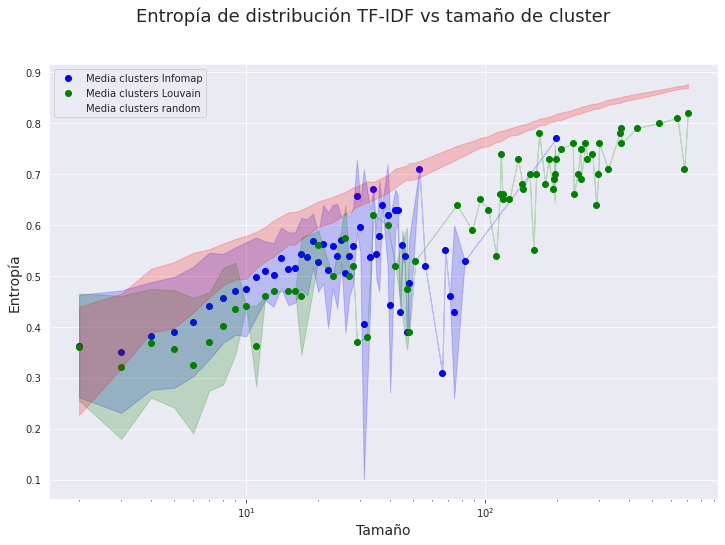

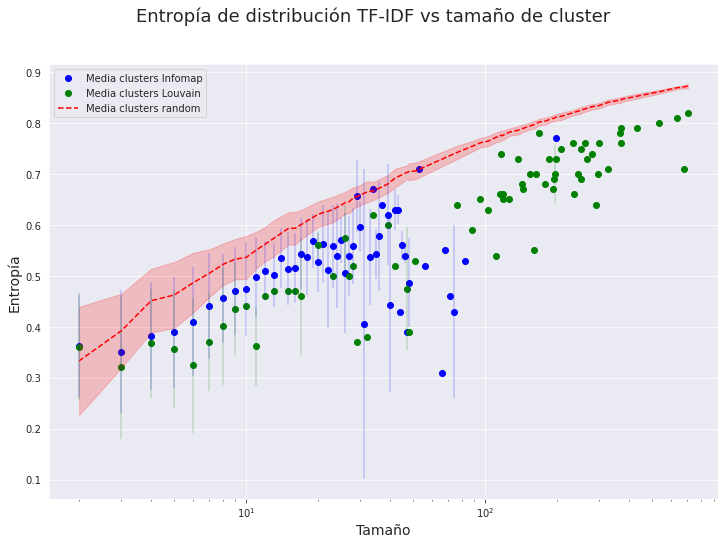

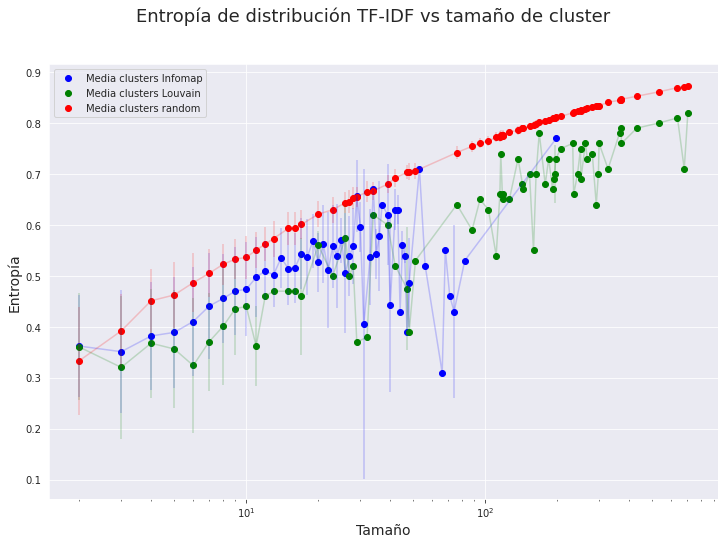

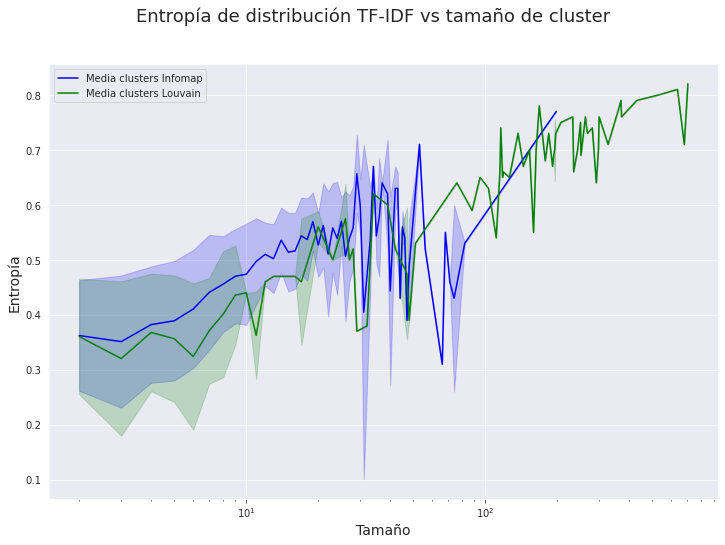

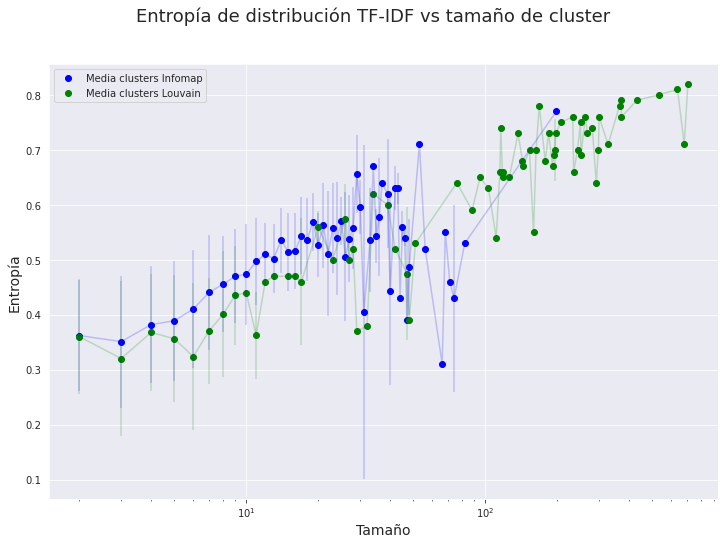

In [83]:
x1, y1, std1 = infomap_clusters_mean_s.index.values, infomap_clusters_mean_s.entropia_1.values, infomap_clusters_std_s.entropia_1.values
x2, y2, std2 = louvain_clusters_mean_s.index.values, louvain_clusters_mean_s.entropia_1.values, louvain_clusters_std_s.entropia_1.values

x2_random, y2_random, std2_random = tamaños_random_louvain, np.array(means_random_louvain[0]), np.array(stds_random_louvain[0])

fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster",fontsize=18)
ax.scatter(x1 , y1, color="b",linestyle='None', label="Media clusters Infomap")
ax.fill_between(x1, y1 - std1, y1 + std1, color='b', alpha=0.2)

ax.scatter(x2 , y2, color= "g",linestyle='None', label="Media clusters Louvain")
ax.fill_between(x2, y2 - std2, y2 + std2, color='g', alpha=0.2)

ax.plot(x2_random , y2_random, "r--",linestyle='None', label="Media clusters random")
ax.fill_between(x2_random, y2_random - std2_random, y2_random + std2_random,linestyle='None', color='r', alpha=0.2)

ax.grid(True)
ax.set_xlabel("Tamaño", fontsize=14)
ax.set_ylabel("Entropía", fontsize=14)
ax.set_xscale("log")
ax.legend()

fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster",fontsize=18)
ax.scatter(x1 , y1, c="b",linestyle='None', label="Media clusters Infomap")
ax.errorbar(x1, y1, std1, color='b',linestyle='None', alpha=0.2)

ax.scatter(x2 , y2, c="g",linestyle='None', label="Media clusters Louvain")
ax.errorbar(x2, y2, std2, color='g',linestyle='None', alpha=0.2)

ax.plot(x2_random , y2_random, "r--", label="Media clusters random")
ax.fill_between(x2_random, y2_random - std2_random, y2_random + std2_random, color='r', alpha=0.2)

ax.grid(True)
ax.set_xlabel("Tamaño", fontsize=14)
ax.set_ylabel("Entropía", fontsize=14)
ax.set_xscale("log")
ax.legend()


fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster",fontsize=18)
ax.scatter(x1 , y1, c="b", label="Media clusters Infomap")
ax.errorbar(x1, y1, std1, color='b', alpha=0.2)

ax.scatter(x2 , y2, c="g", label="Media clusters Louvain")
ax.errorbar(x2, y2, std2, color='g', alpha=0.2)

ax.scatter(x2_random , y2_random, c="r", label="Media clusters random")
ax.errorbar(x2_random, y2_random, std2_random, color='r', alpha=0.2)

ax.grid(True)
ax.set_xlabel("Tamaño", fontsize=14)
ax.set_ylabel("Entropía", fontsize=14)
ax.set_xscale("log")
ax.legend()

fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster",fontsize=18)
ax.plot(x1 , y1, "b-", label="Media clusters Infomap")
ax.fill_between(x1, y1 - std1, y1 + std1, color='b', alpha=0.2)

ax.plot(x2 , y2, "g-", label="Media clusters Louvain")
ax.fill_between(x2, y2 - std2, y2 + std2, color='g', alpha=0.2)

ax.grid(True)
ax.set_xlabel("Tamaño", fontsize=14)
ax.set_ylabel("Entropía", fontsize=14)
ax.set_xscale("log")
ax.legend()

fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster",fontsize=18)
ax.scatter(x1 , y1, c="b", label="Media clusters Infomap")
ax.errorbar(x1, y1, std1, color='b', alpha=0.2)

ax.scatter(x2 , y2, c="g", label="Media clusters Louvain")
ax.errorbar(x2, y2, std2, color='g', alpha=0.2)

ax.grid(True)
ax.set_xlabel("Tamaño", fontsize=14)
ax.set_ylabel("Entropía", fontsize=14)
ax.set_xscale("log")
ax.legend()